<a href="https://colab.research.google.com/github/inokchoi/Speech/blob/main/dvector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plot d-vector embedding

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
cd '/content/drive/My Drive/Colab Notebooks/20-1voice_interface/Proj2/dvector/'

/content/drive/My Drive/Colab Notebooks/20-1voice_interface/Proj2/dvector


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import numpy as np
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from PJ4_dataset import *
from PJ4_model import *

In [ ]:
# Define a collate (stacking) function for the data loader.
def collate_fn(samples):
    data, label = [], []
    min_length = min([len(d[0]) for d in samples])-1

    for d,l in samples:
        st = np.random.randint(len(d)-min_length)
        data.append(torch.tensor(d[st:st+min_length]).unsqueeze(0))
        label.append(torch.tensor(l))
    data = torch.cat(data,0)
    label = torch.LongTensor(label)

    return data, label 

In [ ]:
import matplotlib.pyplot as plt

# Define a t-SNE plot function.
def tsne_plot(vec_tsne, label, path, name):
    cmap = plt.cm.rainbow
    plt.scatter(vec_tsne[:,0], vec_tsne[:,1], s=4, c=label, cmap=cmap)
    plt.xlim(min(vec_tsne[:,0]), max(vec_tsne[:,0]))
    plt.ylim(min(vec_tsne[:,1]), max(vec_tsne[:,1]))
    plt.title(name)
    plt.savefig(path)
    plt.show()
    plt.close()

## Successfully load the model!


100%|██████████| 99/99 [01:45<00:00,  1.06s/it]


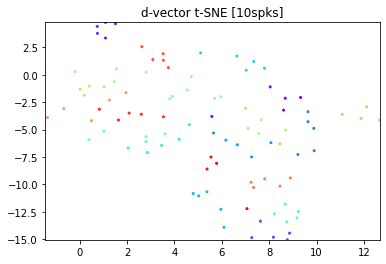

In [ ]:
# Draw a t-SNE plot.
from sklearn.manifold import TSNE

# Set the configuration for training.
n_spk = 29              # number of speakers in the dataset    
feature_type = 'mel'    # input feature type
n_coeff = 13             # feature dimension    
indim = n_coeff*3        # input dimension (MFCC, delta, delta-delta)
context_len = 10         # number of context window
outdim = 512             # d-vector output dimension

# Check if we can use a GPU device.
if torch.cuda.is_available():    
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

model = Dvector(n_spk, indim * context_len, outdim).to(device)

model.eval()
check = torch.load('./model/model_opt_mel.pth')
model.load_state_dict(check['model'])
print('## Successfully load the model!')

# Define a data path for plot.
plot_list='./plot_spk2.txt'
plot_dataset = SpeakerDataset(plot_list, feature_type=feature_type, n_coeff=n_coeff)
plot_loader = DataLoader(plot_dataset,
                         batch_size=1,
                         shuffle=False,
                         collate_fn=collate_fn,
                         num_workers=0,
                         pin_memory=True)
bar = tqdm.tqdm(plot_loader)
output_embedding=[]
output_label=[]
for i, (data,label) in enumerate(bar):
    data = data.type(torch.FloatTensor).to(device)
    output = model(data,extract=False)
    output_embedding.append(output.detach().cpu().numpy())
    output_label.append(label.detach().cpu().numpy()[0])

# Prepare embedings for plot.
output_embedding = np.concatenate(output_embedding)
output_label = np.array(output_label)

# Obtain embedding for the t-SNE plot.
tsne = TSNE(n_components=2)
output_embedding = output_embedding.reshape(len(output_embedding),-1)
vec_tsne = tsne.fit_transform(output_embedding)

# Plot.
tsne_plot(vec_tsne,output_label, './dvec.png','d-vector t-SNE [10spks]')